# Document Classifier Evaluation

In [1]:
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd

# Bulletproof pathing for Jupyter Notebooks
current_dir = Path(os.getcwd())

# Traverse up until we find the root folder that contains 'src'
project_root = current_dir
while not (project_root / "src").exists() and project_root.parent != project_root:
    project_root = project_root.parent

project_root = str(project_root)
src_root = os.path.join(project_root, "src")

# Add to system path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
if src_root not in sys.path:
    sys.path.insert(0, src_root)

print(f"✅ Project Root set to: {project_root}")

# Import your pipeline
from src.utils.document_classification import (
    load_files, extract_text, clean_texts, 
    load_tfidf_model, load_tfidf_vectorizer, classify_document_types
)

CLASSES = {"press_release", "earnings_call", "sec_filing", "news_article", "research_paper"}

✅ Project Root set to: /home/jbatbayar/market-foundry


2026-02-28 09:10:42.284006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-28 09:10:42.284067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-28 09:10:42.285440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-28 09:10:42.291933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def normalize_label(s: str) -> str:
    return s.strip().lower()

def canonical_pred(label: str) -> str:
    """Maps both folder names and model output strings to standard snake_case."""
    l = normalize_label(label)
    if l in {"sec_filing", "sec filing", "sec filing"}: return "sec_filing"
    if l in {"press_release", "press release"}: return "press_release"
    if l in {"earnings_call", "earnings call", "earnings_call_transcript", "earnings call transcript"}: return "earnings_call"
    if l in {"news_article", "news article", "news", "article"}: return "news_article"
    if l in {"research_paper", "research paper", "research", "paper"}: return "research_paper"
    return "other"

In [3]:
def run_evaluation():
    # Construct the absolute path to your eval folder
    eval_root = Path(project_root) / "Papers" / "eval" 
    
    if not eval_root.exists():
        raise FileNotFoundError(f"Eval folder not found: {eval_root.resolve()}")

    # 1. Gather all file paths from the class folders
    file_paths = []
    for cls in CLASSES:
        cls_dir = eval_root / cls
        if cls_dir.exists():
            file_paths.extend([str(p) for p in cls_dir.rglob("*") if p.is_file()])

    if not file_paths:
        raise ValueError("No eval files found under Papers/eval/<class_name>/")

    print(f"🔍 Found {len(file_paths)} files for evaluation. Starting batch processing...")

    # 2. Run your pipeline on the entire batch
    loaded_files = load_files(file_paths)
    texts = extract_text(loaded_files)
    cleaned_texts = clean_texts(texts)

    # Load models
    model_path = os.path.join(src_root, "models", "Document_Classifier.joblib")
    vectorizer_path = os.path.join(src_root, "models", "TFIDF_Vectorizer.joblib")
    
    model = load_tfidf_model(model_path)
    vectorizer = load_tfidf_vectorizer(vectorizer_path)

    # Classify the batch
    print("🧠 Classifying documents...")
    classifications = classify_document_types(model, vectorizer, cleaned_texts)

    # 3. Grade the results
    y_true = []
    y_pred = []
    per_class_counts = Counter()
    confusion = defaultdict(Counter)

    for source_path, pred_str in classifications.items():
        true_label = canonical_pred(Path(source_path).parent.name)
        pred_label = canonical_pred(pred_str)

        if true_label not in CLASSES:
            continue

        y_true.append(true_label)
        y_pred.append(pred_label)

        per_class_counts[true_label] += 1
        confusion[true_label][pred_label] += 1

    # --- Metrics Calculations ---
    correct = sum(t == p for t, p in zip(y_true, y_pred))
    total = len(y_true)
    acc = correct / total if total else 0.0

    metrics = {}
    for cls in sorted(CLASSES):
        tp = sum((t == cls and p == cls) for t, p in zip(y_true, y_pred))
        fp = sum((t != cls and p == cls) for t, p in zip(y_true, y_pred))
        fn = sum((t == cls and p != cls) for t, p in zip(y_true, y_pred))

        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

        metrics[cls] = {"Precision": precision, "Recall": recall, "F1": f1, "Support": per_class_counts[cls]}

    macro_f1 = sum(m["F1"] for m in metrics.values()) / len(CLASSES)
    weighted_f1 = sum(m["Support"] * m["F1"] for m in metrics.values()) / total if total else 1

    # Return everything so you can use it in the notebook
    return {
        "total": total,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "class_metrics": metrics,
        "confusion_matrix": confusion
    }

## V1

## V2

In [10]:
# Run the evaluation and capture the output
results = run_evaluation()

print(f"Overall Accuracy:  {results['accuracy']:.3f}")
print(f"Macro F1 Score:    {results['macro_f1']:.3f}")
print(f"Weighted F1 Score: {results['weighted_f1']:.3f}\n")

# Display Per-Class Metrics as a DataFrame
df_metrics = pd.DataFrame(results['class_metrics']).T
display(df_metrics.round(3))

# Display Confusion Matrix as a DataFrame
df_confusion = pd.DataFrame(results['confusion_matrix']).fillna(0).astype(int)
print("\nConfusion Matrix (Rows = True, Columns = Predicted):")
display(df_confusion)

🔍 Found 85 files for evaluation. Starting batch processing...
Loaded 85 files in 92.50 seconds.
🧠 Classifying documents...
📂 Building reference cache from /home/jbatbayar/market-foundry/src/knn_pipeline/reference_docs...
✅ Classifier ready with 67 reference examples. Cache saved.
Disagreement in classification for are-we-in-an-economic-doom-loop.html → Resolved to News Article
Disagreement in classification for anthropic-claude-380b-valuation-openai-rivalry-ipo.html → Resolved to News Article
Disagreement in classification for ubs-lifts-forecast-big-tech-bond-sales-this-year.html → Resolved to News Article
Disagreement in classification for sony-japan-entertainment-electronics-games.pdf → Resolved to News Article
Disagreement in classification for HSBC_cuts_10%_of_US_debt_capital.html → Resolved to News Article
Disagreement in classification for ecb-fines-jpmorgan-122-mln-euros-misreporting-capital-requirements.html → Resolved to News Article
Disagreement in classification for Nvidia_c

,Precision,Recall,F1,Support
earnings_call,1.000,0.923,0.960,13.0
news_article,0.462,1.000,0.632,12.0
press_release,1.000,0.100,0.182,20.0
research_paper,1.000,0.857,0.923,7.0
sec_filing,0.760,1.000,0.864,19.0



Confusion Matrix (Rows = True, Columns = Predicted):


,news_article,press_release,sec_filing,earnings_call,research_paper
news_article,12,14,0,0,0
sec_filing,0,4,19,1,1
press_release,0,2,0,0,0
earnings_call,0,0,0,12,0
research_paper,0,0,0,0,6


In [11]:
print(df_metrics.round(3))

                Precision  Recall     F1  Support
earnings_call       1.000   0.923  0.960     13.0
news_article        0.462   1.000  0.632     12.0
press_release       1.000   0.100  0.182     20.0
research_paper      1.000   0.857  0.923      7.0
sec_filing          0.760   1.000  0.864     19.0


In [12]:
print(df_confusion)

                news_article  press_release  sec_filing  earnings_call  \
news_article              12             14           0              0   
sec_filing                 0              4          19              1   
press_release              0              2           0              0   
earnings_call              0              0           0             12   
research_paper             0              0           0              0   

                research_paper  
news_article                 0  
sec_filing                   1  
press_release                0  
earnings_call                0  
research_paper               6  


## V3

In [7]:
# Run the evaluation and capture the output
results = run_evaluation()

print(f"Overall Accuracy:  {results['accuracy']:.3f}")
print(f"Macro F1 Score:    {results['macro_f1']:.3f}")
print(f"Weighted F1 Score: {results['weighted_f1']:.3f}\n")

# Display Per-Class Metrics as a DataFrame
df_metrics = pd.DataFrame(results['class_metrics']).T
display(df_metrics.round(3))

# Display Confusion Matrix as a DataFrame
df_confusion = pd.DataFrame(results['confusion_matrix']).fillna(0).astype(int)
print("\nConfusion Matrix (Rows = True, Columns = Predicted):")
display(df_confusion)

🔍 Found 85 files for evaluation. Starting batch processing...
Loaded 85 files in 96.27 seconds.
🧠 Classifying documents...
📂 Building reference cache from /home/jbatbayar/market-foundry/src/knn_pipeline/reference_docs...
✅ Classifier ready with 74 reference examples. Cache saved.
Disagreement in classification for are-we-in-an-economic-doom-loop.html → Resolved to News Article
Disagreement in classification for anthropic-claude-380b-valuation-openai-rivalry-ipo.html → Resolved to News Article
Disagreement in classification for ubs-lifts-forecast-big-tech-bond-sales-this-year.html → Resolved to News Article
Disagreement in classification for sony-japan-entertainment-electronics-games.pdf → Resolved to News Article
Disagreement in classification for HSBC_cuts_10%_of_US_debt_capital.html → Resolved to News Article
Disagreement in classification for ecb-fines-jpmorgan-122-mln-euros-misreporting-capital-requirements.html → Resolved to News Article
Disagreement in classification for Nvidia_c

,Precision,Recall,F1,Support
earnings_call,1.000,0.923,0.960,13.0
news_article,0.500,1.000,0.667,12.0
press_release,1.000,0.250,0.400,20.0
research_paper,1.000,0.857,0.923,7.0
sec_filing,0.792,1.000,0.884,19.0



Confusion Matrix (Rows = True, Columns = Predicted):


,news_article,press_release,earnings_call,sec_filing,research_paper
news_article,12,12,0,0,0
press_release,0,5,0,0,0
sec_filing,0,3,1,19,1
earnings_call,0,0,12,0,0
research_paper,0,0,0,0,6


In [8]:
print(df_metrics.round(3))

                Precision  Recall     F1  Support
earnings_call       1.000   0.923  0.960     13.0
news_article        0.500   1.000  0.667     12.0
press_release       1.000   0.250  0.400     20.0
research_paper      1.000   0.857  0.923      7.0
sec_filing          0.792   1.000  0.884     19.0


In [9]:
print(df_confusion)

                news_article  press_release  earnings_call  sec_filing  \
news_article              12             12              0           0   
press_release              0              5              0           0   
sec_filing                 0              3              1          19   
earnings_call              0              0             12           0   
research_paper             0              0              0           0   

                research_paper  
news_article                 0  
press_release                0  
sec_filing                   1  
earnings_call                0  
research_paper               6  


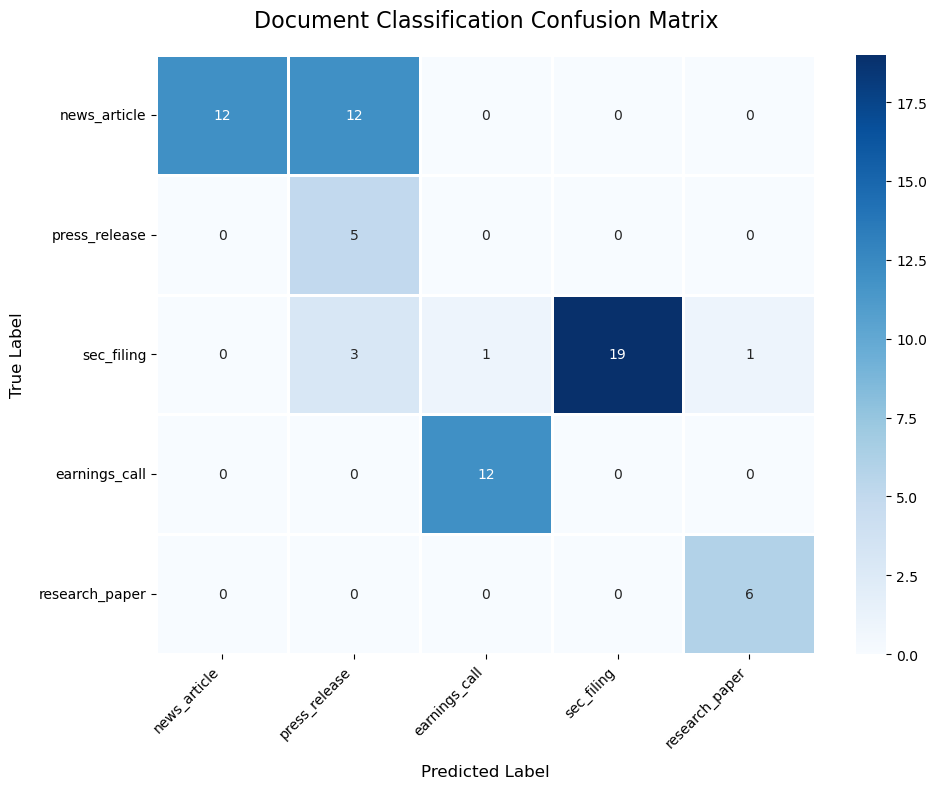

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure size
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(
    df_confusion, 
    annot=True,          # Show the numbers inside the squares
    fmt='d',             # Format as whole integers
    cmap='Blues',        # Use a clean blue color scale
    linewidths=1,        # Add gridlines
    cbar=True,           # Show the color legend
    xticklabels=df_confusion.columns, 
    yticklabels=df_confusion.index
)

# Add titles and labels
plt.title('Document Classification Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
plt.ylabel('True Label', fontsize=12, labelpad=10)

# Rotate x-axis labels so they are easy to read
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()